In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
df = pd.read_csv("gym_members_exercise_tracking.csv")
df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

## 1. Выбор атрибута и оценка сбалансированности классов
В качестве целевого атрибута был выбран признак *Activity_Type*.  
Выбор обусовлен следующими причинами:
+ Смысловая обоснованность  
  Тип активности логично предсказывать на основе других характеристик тренировки.
+ Категориальный тип
+ Многоклассовый  
  Принимает 4 значения: Strength, Cardio, Yoga, HIIT.

Количество объектов в классах:
Workout_Type
Strength    258
Cardio      255
Yoga        239
HIIT        221
Name: count, dtype: int64 



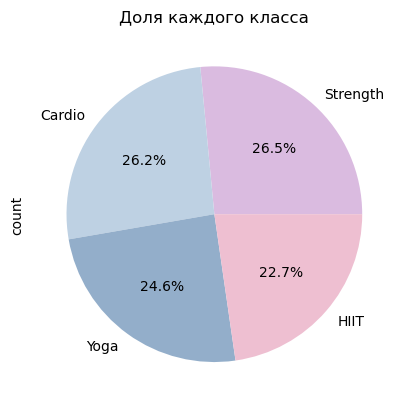

In [4]:
class_distribution = df['Workout_Type'].value_counts()
print("Количество объектов в классах:")
print(class_distribution, "\n")

class_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['#DABBE0', '#BED1E3', '#93AECA', '#EEBFD1'])
plt.title('Доля каждого класса')
plt.show()

Классы имеют примерно равное количество наблюдений, что говорит об отсутствии сильного дисбаланса (разница в долях < 4%).

## 2. Оценка и сравнение результатов классификации
### 2.1. Подготовка данных 

In [5]:
df_encoded = df.copy()
df_encoded = df_encoded.drop_duplicates().reset_index(drop=True)

#Кодирование категориальных признаков
df_encoded['Gender'] = LabelEncoder().fit_transform(df_encoded['Gender'])
df_encoded['Workout_Type_encoded'] = LabelEncoder().fit_transform(df_encoded['Workout_Type'])

X = df_encoded.drop(columns=['Workout_Type'])
y = df_encoded['Workout_Type_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.2. kNN

k = 9
accuracy = 0.609


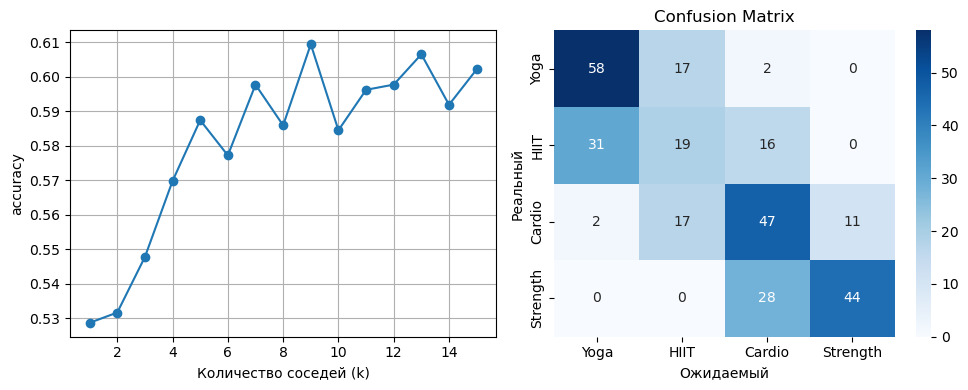

In [6]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 16)}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
print(f"k = {best_k}")
print(f"accuracy = {best_score:.3f}")

knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)
y_pred_knn = knn_best.predict(X_test_scaled)
y_proba_knn = knn_best.predict_proba(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
results = grid_search.cv_results_
plt.plot(range(1, 16), results['mean_test_score'], marker='o')
plt.xlabel('Количество соседей (k)')
plt.ylabel('accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Yoga', 'HIIT', 'Cardio', 'Strength'],
            yticklabels=['Yoga', 'HIIT', 'Cardio', 'Strength'], ax=axes[1])
plt.title('Confusion Matrix')
plt.xlabel('Ожидаемый')
plt.ylabel('Реальный')

plt.tight_layout()
plt.show()

### 2.3. Дерево решений

Оптимальные параметры: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
accuracy = 1.000

Важность признаков:
                          Признак  Важность
14           Workout_Type_encoded       1.0
1                          Gender       0.0
0                             Age       0.0
3                      Height (m)       0.0
4                         Max_BPM       0.0
5                         Avg_BPM       0.0
2                     Weight (kg)       0.0
6                     Resting_BPM       0.0
7        Session_Duration (hours)       0.0
9                  Fat_Percentage       0.0
8                 Calories_Burned       0.0
10          Water_Intake (liters)       0.0
11  Workout_Frequency (days/week)       0.0
12               Experience_Level       0.0
13                            BMI       0.0


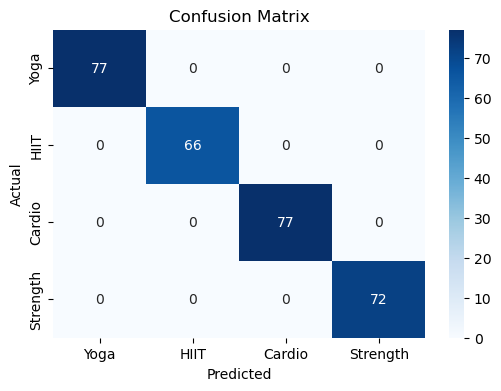

In [7]:
dt = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

dt_best = grid_search_dt.best_estimator_
dt_best.fit(X_train, y_train)
y_pred_dt = dt_best.predict(X_test)
y_proba_dt = dt_best.predict_proba(X_test)

print(f"Оптимальные параметры: {grid_search_dt.best_params_}")
print(f"accuracy = {grid_search_dt.best_score_:.3f}")

feature_importance = pd.DataFrame({'Признак': X.columns,'Важность': dt_best.feature_importances_}).sort_values('Важность', ascending=False)
print("\nВажность признаков:")
print(feature_importance)

plt.figure(figsize=(6, 4))
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Yoga', 'HIIT', 'Cardio', 'Strength'],
            yticklabels=['Yoga', 'HIIT', 'Cardio', 'Strength'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 3. Сравнение результатов с помощью метрик оценки качества
### 3.1. Accuracy, Presicion, Recall, F-measure

In [8]:
def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

acc_knn, prec_knn, rec_knn, f1_knn = get_metrics(y_test, y_pred_knn)
acc_dt, prec_dt, rec_dt, f1_dt = get_metrics(y_test, y_pred_dt)

print(f"{'Метрика':<10} {'kNN':<10} {'Decision Tree':<15}")
print(f"{'-'*50}")
print(f"{'Accuracy':<10} {acc_knn:<10.4f} {acc_dt:<15.4f}")
print(f"{'Precision':<10} {prec_knn:<10.4f} {prec_dt:<15.4f}")
print(f"{'Recall':<10} {rec_knn:<10.4f} {rec_dt:<15.4f}")
print(f"{'F-measure':<10} {f1_knn:<10.4f} {f1_dt:<15.4f}")

Метрика    kNN        Decision Tree  
--------------------------------------------------
Accuracy   0.5753     1.0000         
Precision  0.5796     1.0000         
Recall     0.5753     1.0000         
F-measure  0.5709     1.0000         


### 3.2. ROC

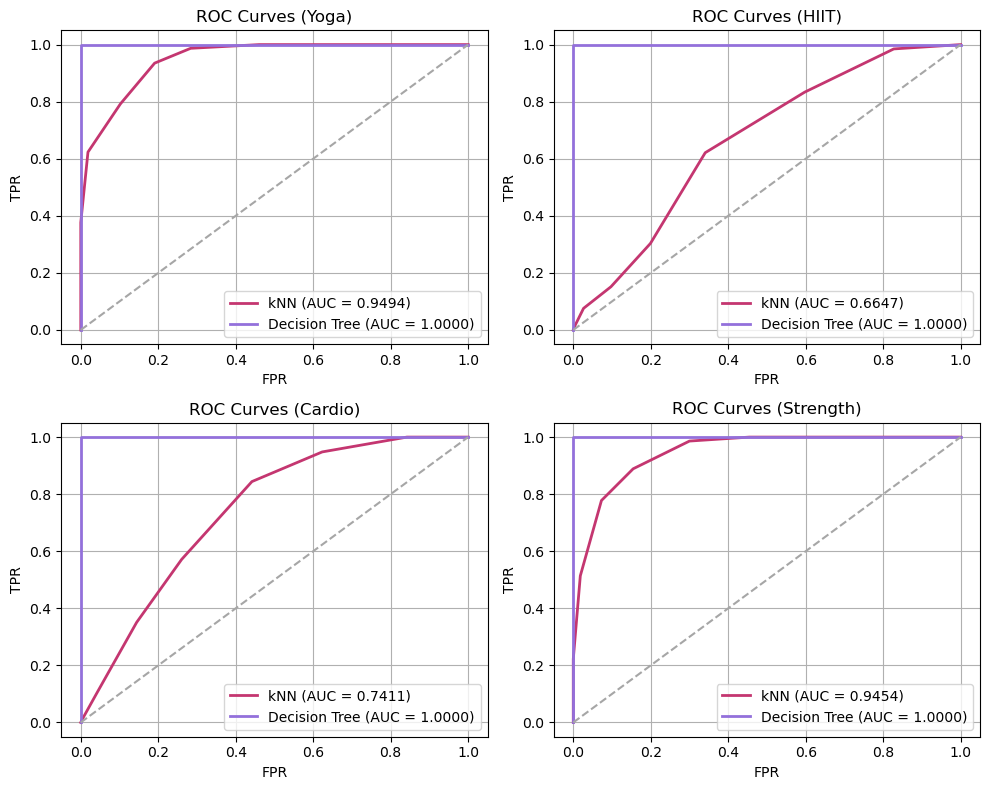

In [9]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

for i, class_name in enumerate(['Yoga', 'HIIT', 'Cardio', 'Strength']):
    fpr_knn, tpr_knn, _ = roc_curve(y_test_bin[:, i], y_proba_knn[:, i])
    roc_auc_knn = auc(fpr_knn, tpr_knn)

    fpr_dt, tpr_dt, _ = roc_curve(y_test_bin[:, i], y_proba_dt[:, i])
    roc_auc_dt = auc(fpr_dt, tpr_dt)

    axs[i].plot(fpr_knn, tpr_knn, color='#C43670', lw=2, label=f"kNN (AUC = {roc_auc_knn:.4f})")
    axs[i].plot(fpr_dt, tpr_dt, color='#9370DB', lw=2, label=f"Decision Tree (AUC = {roc_auc_dt:.4f})")
    axs[i].plot([0,1], [0,1], color='#A6A6A6', linestyle='--')
    axs[i].set_xlabel("FPR")
    axs[i].set_ylabel("TPR")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"ROC Curves ({class_name})")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

## 4. Анализ полученных результатов
+ **kNN:**  
  Алгоритм показал умеренные значения метрик качества, что свидетельствует о способности корректно классификацировать лишь часть объектов.
  Причиной такого результата может быть то, что метод kNN основывается на расстояниях между объектами и предполагает наличие чётко разделённых
  кластеров. В данном датасете признаки различных типов активности частично перекрываются, что снижает эффективность kNN.  
+ **Дерево решений:**  
  Алгоритм продемонстрировал идеальные значения всех используемых метрик, что свидетельствует о безошибочной классификации всех объектов.  
+ Анализ **ROC-кривых** показал, что:
  + ROC-кривые дерева решений в располагаются выше, чем у kNN, что означает более высокую способность дерева решений различать классы;
  + наилучшие результаты достигнуты для класса Strength;
  + хуже всего классифицируются HIIT тренировки.        

Таким образом, для данной задачи классификации дерево решений оказалось существенно более эффективным алгоритмом по сравнению с kNN.